In [13]:
import wave
import numpy as np
import librosa as lb
import librosa.display
from scipy.signal import butter, filtfilt
import os
import matplotlib.pyplot as plt

In [2]:
sample_data_path = 'E:\Datasets/barbie_vs_puppy/barbie/barbie_4.wav'

with wave.open(sample_data_path) as wave_file:
    frame_rate = wave_file.getframerate()
frame_rate

48000

#### Resampling
##### - adjusting the number of samples per second while preserving the original content’s perceptual characteristics

In [3]:
def resample_audio(audio_path, target_sr = 16000):
    y, sr = lb.load(audio_path, sr = target_sr)
    return y, sr
resampled_audio, sr = resample_audio(sample_data_path)
print(f"sample rate after resampling: {sr}")

sample rate after resampling: 16000


#### Filtering
##### - to modify the frequency content of an audio signal by attenuating or emphasizing certain frequency components
##### - (butter_lowpass_filter) to remove the background noises

In [4]:
def ButterLowPass_filter (data, cutoff_freq, sample_rate, order = 4):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype = 'low', analog = False)
    filtered_data = filtfilt(b, a, data)
    print(f"filtered audio shape: {filtered_data.shape}")
    return filtered_data
filtered_audio = ButterLowPass_filter(resampled_audio, cutoff_freq = 4000, sample_rate = sr)

filtered audio shape: (31403,)


#### Convert to the model's expected input 

In [5]:
def convert_input(y, target_length):
    if len(y) < target_length:
        y = np.pad(y, (0,target_length - len(y)))
    else:
        y = y[:target_length]
    return y
model_inp = convert_input (filtered_audio, target_length = 16000)
print(f"Input shape: {model_inp.shape}")

Input shape: (16000,)


#### Streaming 
##### - streaming allows the model to process data in chunks or batches which facilitates efficient memory usage and enables the model to handle datasets that may not fit entirely into memory

In [10]:
def stream_audio_dataset(dataset_path, batch_size=32, target_length=16000, target_sr=None):
    # Get all audio file paths in the dataset path
    audio_files = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files]

    # Shuffle the audio files for randomness
    np.random.shuffle(audio_files)

    # Yield batches of audio data
    for i in range(0, len(audio_files), batch_size):
        batch_paths = audio_files[i:i + batch_size]
        batch_data = []

        for file_path in batch_paths:
            # Load and preprocess each audio file
            y, sr = lb.load(file_path, sr=target_sr)

            # Resampling
            if target_sr is not None and sr != target_sr:
                y = lb.resample(y, sr, target_sr)
                sr = target_sr

            filtered_audio = ButterLowPass_filter(y, cutoff_freq=4000, sample_rate=sr)
            model_input = convert_input(filtered_audio, target_length=target_length)
            batch_data.append(model_input)

        yield np.array(batch_data)

# Load the dataset folder
dataset_path = 'E:\Datasets/barbie_vs_puppy/barbie/'

for batch_data in stream_audio_dataset(dataset_path, batch_size=5, target_sr=16000):
    # Process each batch of audio data
    print(f"Processing batch with {len(batch_data)} files")

    # Print the shape of the first file in the batch
    print(f"Shape of the first file: {batch_data[0].shape}")


filtered audio shape: (26966,)
filtered audio shape: (36864,)
filtered audio shape: (37547,)
filtered audio shape: (51542,)
filtered audio shape: (24918,)
Processing batch with 5 files
Shape of the first file: (16000,)
filtered audio shape: (49280,)
filtered audio shape: (31360,)
filtered audio shape: (23520,)
filtered audio shape: (36182,)
filtered audio shape: (30720,)
Processing batch with 5 files
Shape of the first file: (16000,)
filtered audio shape: (39200,)
filtered audio shape: (38571,)
filtered audio shape: (36088,)
filtered audio shape: (29365,)
filtered audio shape: (30379,)
Processing batch with 5 files
Shape of the first file: (16000,)
filtered audio shape: (31403,)
filtered audio shape: (88406,)
filtered audio shape: (38080,)
filtered audio shape: (26966,)
filtered audio shape: (25600,)
Processing batch with 5 files
Shape of the first file: (16000,)
filtered audio shape: (33792,)
filtered audio shape: (33792,)
filtered audio shape: (23520,)
filtered audio shape: (27596,)


#### Log Mel-Spectrogram

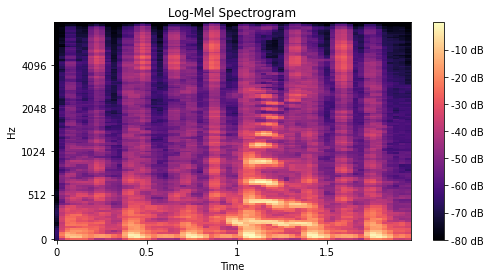

In [14]:
# visualizing log-mel spectrogram
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = lb.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram
 
# load the audio file
audio_file_path = 'E:\Datasets/barbie_vs_puppy/barbie/barbie_4.wav'
target_sr = 16000
 
# Load the audio file
y, sr = lb.load(audio_file_path, sr=target_sr)
 
# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(y, sr=sr)
 
# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

#### Framing

In [33]:
# load the audio file
audio_file_path = 'E:\Datasets/barbie_vs_puppy/barbie/barbie_4.wav'
target_sr = 16000
 
# Load the audio file
x, sr = lb.load(audio_file_path, sr=target_sr)
frames = lb.util.frame(x, frame_length=400, hop_length=160)
xt = np.transpose(frames)
xt.shape

(194, 400)

Energy

In [34]:
frame_energy = np.sum(xt**2, axis =1)
print(f"frame_energy: {frame_energy.shape}")
energy_thr = 0.001*np.max(frame_energy)
print(energy_thr)
# finding the none-silence index
nonSilenceIndex = np.argmax(frame_energy > energy_thr)
nonSilenceIndex

frame_energy: (194,)
0.012502779006958007


4

In [35]:
# finding the first none-zero index 
fnz_idx = np.any(xt, axis=(1)).argmax()
print(fnz_idx)
xt_trunc = xt[fnz_idx:,:]
print(f"xt shape:{xt_trunc.shape}")
if fnz_idx != 0:
    print("y")
else:
    print("N")

2
xt shape:(192, 400)
y


#### Length and Duration

In [17]:
# finding the length and duration of samples
audio_lengths =[]
audio_durations =[]
myPath = 'E:\Datasets/barbie_vs_puppy/'
for roots, dirs, files in os.walk(myPath):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(roots,file)
            signal, sr = lb.load(file_path, sr=None)
            # lengths
            length = len(signal)
            audio_lengths.append(length)
            # durations
            duration = lb.get_duration(y = signal, sr = sr)
            audio_durations.append(duration)

In [18]:
# maximum values
max_length = max(audio_lengths)
max_duration = max(audio_durations)
print(f"duration: {max_duration} seconds")
print(f"length: {max_length}")

duration: 5.525333333333333 seconds
length: 265216


In [19]:
# min values
min_length = min(audio_lengths)
min_duration = min(audio_durations)
print(f"duration: {min_duration}")
print(f"length: {min_length}")

duration: 1.12
length: 53760


#### MFCC
##### MFCC feature extraction with framing

In [22]:
def MFCC_featureExtraction(file_path):
    
    ## load the audio file
    x, sample_rate = lb.load(file_path, res_type='kaiser_fast')
   
    ## extract mffcs
    
    frames = lb.util.frame(x, frame_length=400, hop_length=160)
    xt = np.transpose(frames)
    #print(xt.shape)
    
    #num_frames = []
    #num_frames.append(xt[:,1]) 
    #print(num_frames)
    mfccs = lb.feature.mfcc(y=xt, sr=sample_rate, n_mfcc = 13)

   
    ## normalize mfccs
    
    mfccs_norm = (mfccs-mfccs.mean())/mfccs.std()
    #mfccs_norm = np.mean(mfccs.T, axis = 0)
    print(f" mfcc shape: {mfccs_norm.shape}")
    return mfccs_norm

In [24]:
features = {}
for roots, dirs, files in os.walk(myPath):
    for fName in files:
        file_path = os.path.join(roots,fName)
        Name = fName.split('.')[0] # name without extension
        #fileNames.append(Name)
        #print("new command:",file_path.split('/')[-1].split('.')[0])
        features[fName] = MFCC_featureExtraction(file_path)

C:\Users\Farnoush\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=400
  return f(*args, **kwargs)


 mfcc shape: (461, 13, 1)
 mfcc shape: (365, 13, 1)
 mfcc shape: (330, 13, 1)
 mfcc shape: (321, 13, 1)
 mfcc shape: (268, 13, 1)
 mfcc shape: (201, 13, 1)
 mfcc shape: (289, 13, 1)
 mfcc shape: (336, 13, 1)
 mfcc shape: (365, 13, 1)
 mfcc shape: (422, 13, 1)
 mfcc shape: (210, 13, 1)
 mfcc shape: (268, 13, 1)
 mfcc shape: (219, 13, 1)
 mfcc shape: (152, 13, 1)
 mfcc shape: (201, 13, 1)
 mfcc shape: (236, 13, 1)
 mfcc shape: (268, 13, 1)
 mfcc shape: (309, 13, 1)
 mfcc shape: (310, 13, 1)
 mfcc shape: (251, 13, 1)
 mfcc shape: (270, 13, 1)
 mfcc shape: (310, 13, 1)
 mfcc shape: (243, 13, 1)
 mfcc shape: (227, 13, 1)
 mfcc shape: (230, 13, 1)
 mfcc shape: (266, 13, 1)
 mfcc shape: (231, 13, 1)
 mfcc shape: (208, 13, 1)
 mfcc shape: (201, 13, 1)
 mfcc shape: (263, 13, 1)
 mfcc shape: (345, 13, 1)
 mfcc shape: (321, 13, 1)
 mfcc shape: (230, 13, 1)
 mfcc shape: (213, 13, 1)
 mfcc shape: (268, 13, 1)
 mfcc shape: (348, 13, 1)
 mfcc shape: (280, 13, 1)
 mfcc shape: (230, 13, 1)
 mfcc shape:

#### Zero padding

In [28]:
# Load the audio file
x, sr = lb.load(audio_file_path, sr=target_sr)
frames = lb.util.frame(x, frame_length=400, hop_length=160)
xt = np.transpose(frames)
xt.shape

(194, 400)

In [32]:
target = 1000
mfccs = lb.feature.mfcc(y=xt, sr=sr, n_mfcc = 13)
print(f"mfccs: {mfccs.shape}")
pad_width = target - mfccs.shape[0]
if pad_width > 0:
        mfccs_norm1 = np.pad(mfccs, pad_width=((0,pad_width),(0,0),(0,0)), mode = 'constant')
        print("padded mfcc:", mfccs_norm1.shape)        
elif pad_width <= 0:
        mfccs_norm1 = mfccs[0:target,:,:]
        print("padded mfcc:", mfccs_norm1)      

mfccs: (194, 13, 1)
padded mfcc: (1000, 13, 1)
